In [1]:
import numpy as np
import torch
from mpc_mpnet_planner import MPCMPNetPlanner
from matplotlib import pyplot as plt
from mpnet.sst_envs.utils import load_data, visualize_point, get_obs
import pickle
from params.step5_s1024_e32 import get_params


In [2]:
env_id = 0
traj_id = 1
obs_list = get_obs('acrobot_obs', env_id)
data = load_data('acrobot_obs', env_id, traj_id)
ref_path = data['path']
env_vox = torch.from_numpy(np.load('mpnet/sst_envs/acrobot_obs_env_vox.npy')[env_id]).unsqueeze(0).float()
params = get_params(ref_path[-1])

In [19]:
## for params
n_t = 5
state_dim = 4
control_dim = 1
weights = np.ones(state_dim)*1
weights[2:] = 0.2
n_sample = 1024
n_elite = 32
t = 1e-1
dt = 2e-2

mu_t, sigma_t = 1e-1, 4e-1
t_min, t_max = 0, 5e-1

mu_u = np.zeros((n_t*control_dim))
sigma_u_diag = np.ones(n_t*control_dim)
sigma_u_diag[:] = 8
sigma_u = np.diag(sigma_u_diag)
params = {
    'n_sample': n_sample,
    'n_elite': n_elite,
    'n_t': n_t,
    'weights': weights,
    'mu_u': mu_u,
    'sigma_u': sigma_u,
    't': t,
    'dt': dt,

    'mu_t': np.ones(n_t) * mu_t,
    'sigma_t': np.identity(n_t)*sigma_t,
    't_min': t_min,
    't_max': t_max,

    'state_dim': state_dim,
    'control_dim': control_dim,
    'converge_radius': 1e-2,
    'drop_radius': 1,
    'goal_radius': 1, #np.sqrt(2),
    'max_it': 20,
    'rolling_count': n_t,
    'bk_it': 2,
    'final_goal': ref_path[-1],
    'mpc_mode': 'solve',#'mpc_mode': 'rolling'
    'max_plan_it': 300,
    
    
#     'planning_mode': 'line_search',
    'planning_mode': 'tree',
    'delta_near': 5e-1,
    'delta_drain': 1e-3,
#     'tree_sample': False,
    'tree_sample': True
}


In [20]:
import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')
from sparse_rrt import _sst_module
class AcrobotDistance(_sst_module.IDistance):
    '''
    Custom distance function for acrobot in python (reimplementation of cpp distance function)
    '''
    def angular_error(self, state, goal):
        error = np.abs(state - goal)
        if error > np.pi:
            error = np.pi * 2 - error
        return error
    
    def distance(self, state, goal):
        return self.angular_error(state[0], goal[0]) * params['weights'][0] +\
            self.angular_error(state[1], goal[1]) * params['weights'][1] + \
            (state[2] - goal[2]) ** 2 * params['weights'][2] +\
            (state[3] - goal[3]) ** 2 * params['weights'][2]

In [21]:
%%time
mpc_mpnet = MPCMPNetPlanner(params,
                            ref_path[0], 
                            ref_path[-1],
                            env_vox,
                            system="acrobot_obs",
                            setup="default_norm",
                            #setup="default_norm_aug",
#                             setup="norm_nodiff_noaug_20step2e-2",
                            ep=5000,
                            obs_list=obs_list[env_id], verbose=True,
                            #distance_func=AcrobotDistance()
                           )
# mpc_mpnet.mpnet.train()
mpc_mpnet.mpnet.eval()
mpc_mpnet.reset_sst_backend()

it = 0
while it < 90 and not mpc_mpnet.reached:
    mpc_mpnet.reset()
    for i in range(20):
        print('iteration:{}, it:{}'.format(i, it))
        mpc_mpnet.step()
        if mpc_mpnet.reached:
            break
        it += 1

print(sum(mpc_mpnet.costs),'ref:', sum(data['cost']))

iteration:0, it:0
[75.42694803]
0.4703909687822984 inf
0.5065173213405143 0.4703909687822984
0.46780998279931757 0.4703909687822984
0.47141214250574437 0.46780998279931757
loss: [0.07027712]
iteration:1, it:1
[74.36469394]
0.25483771864643 inf
0.2533262011588404 0.25483771864643
0.2611267237992881 0.2533262011588404
0.2586277264716471 0.2533262011588404
0.2541903948407096 0.2533262011588404
0.2600570820591565 0.2533262011588404
0.25760493366358767 0.2533262011588404
0.25244414233365076 0.2533262011588404
0.25825729133881087 0.25244414233365076
0.25543729056622955 0.25244414233365076
0.26917826298485736 0.25244414233365076
0.2658384890231784 0.25244414233365076
0.2661352235154466 0.25244414233365076
0.267720925667262 0.25244414233365076
0.24862809445223458 0.25244414233365076
0.2525107466868382 0.24862809445223458
0.2623362759746543 0.24862809445223458
0.2566331431431468 0.24862809445223458
0.25876728910441293 0.24862809445223458
0.26304882432800497 0.24862809445223458
0.266140525323956

0.3407279210856475 inf
0.2736087489070454 0.3407279210856475
0.2691589816541202 0.2736087489070454
0.27922940138888597 0.2691589816541202
0.27847259431152116 0.2691589816541202
0.2775193128243771 0.2691589816541202
0.2766053328266195 0.2691589816541202
0.2759612346000897 0.2691589816541202
loss: [0.01702915]
iteration:19, it:19
[37.5307011]
1.963844748204235 inf
1.5034806243992387 1.963844748204235
1.4719837838995105 1.5034806243992387
1.3443976999290017 1.4719837838995105
1.3084303738058767 1.3443976999290017
1.2913505662818159 1.3084303738058767
1.2635381102278473 1.2913505662818159
1.2839380188095333 1.2635381102278473
1.2513200703470937 1.2635381102278473
1.2626884899662905 1.2513200703470937
1.255850483910661 1.2513200703470937
1.269250310394083 1.2513200703470937
1.2648717692972855 1.2513200703470937
1.2651793790832229 1.2513200703470937
1.273323590646222 1.2513200703470937
1.264162548886322 1.2513200703470937
1.270375496100065 1.2513200703470937
1.2712507271878328 1.251320070347

1.2460139071603915 1.2518074000789616
1.2382779059501032 1.2460139071603915
1.2417951514350936 1.2382779059501032
1.2411528653553625 1.2382779059501032
1.2342446709274157 1.2382779059501032
1.2322500090037365 1.2342446709274157
1.2300847485967539 1.2322500090037365
1.2234657200160373 1.2300847485967539
converged at  4
loss: [0.00924803]
iteration:12, it:32
[3.07319567]
0.25464742610076463 inf
0.2283506554989424 0.25464742610076463
0.2276375090471403 0.2283506554989424
0.22670111905455193 0.2276375090471403
0.22778503990324367 0.22670111905455193
0.2233520678257343 0.22670111905455193
0.2271497152082647 0.2233520678257343
0.22840213733060716 0.2233520678257343
0.22657428830396265 0.2233520678257343
0.22692122422610694 0.2233520678257343
0.22933664458710812 0.2233520678257343
0.22703628942336504 0.2233520678257343
0.22795180277879512 0.2233520678257343
0.22798090841123253 0.2233520678257343
0.2293891575720861 0.2233520678257343
0.22957979470171766 0.2233520678257343
0.22927092104835034 0

1.3860713517118646 inf
1.7647503896530936 1.3860713517118646
1.74769875406125 1.3860713517118646
1.399295245350823 1.3860713517118646
1.4800568696105958 1.3860713517118646
1.4409382471251866 1.3860713517118646
1.4275394064815863 1.3860713517118646
1.4352525801238212 1.3860713517118646
1.4399173519218462 1.3860713517118646
1.506112563826577 1.3860713517118646
1.481424700485185 1.3860713517118646
1.4633381653431996 1.3860713517118646
1.4479226073303588 1.3860713517118646
1.5874675801469367 1.3860713517118646
1.4384653006160175 1.3860713517118646
1.5178861890421036 1.3860713517118646
1.3969057080004548 1.3860713517118646
1.3995655493545844 1.3860713517118646
1.4175275818863997 1.3860713517118646
1.4260505654773854 1.3860713517118646
1.59302098788435 1.3860713517118646
loss: [0.15354741]
iteration:5, it:45
[3.90313136]
1.7693673422284475 inf
1.6538112854224671 1.7693673422284475
1.447035264585377 1.6538112854224671
1.3942127512042928 1.447035264585377
converged at  3
loss: [0.004639]
itera

0.22824073051339366 0.2167657714363886
0.23056943322762696 0.2167657714363886
0.22754067287883672 0.2167657714363886
0.23289369165121204 0.2167657714363886
loss: [0.08536622]
iteration:2, it:62
[1.38611734]
1.6385297359238256 inf
1.6367143540519944 1.6385297359238256
1.3640059092733157 1.6367143540519944
1.3961801166904513 1.3640059092733157
1.3607008758288768 1.3640059092733157
1.286844565139339 1.3607008758288768
1.262795943434932 1.286844565139339
1.2682010695553327 1.262795943434932
1.286719392170412 1.262795943434932
1.2567251914815853 1.262795943434932
1.2589274609160344 1.2567251914815853
1.2725922256349813 1.2567251914815853
1.2689918344080866 1.2567251914815853
1.2684547879383858 1.2567251914815853
1.2628487655436844 1.2567251914815853
1.2551689169438183 1.2567251914815853
1.2648755340178306 1.2551689169438183
1.2511720403354156 1.2551689169438183
1.2471744492495065 1.2511720403354156
1.2506224006117832 1.2471744492495065
1.2564332933561566 1.2471744492495065
loss: [0.02601434

0.28958925014684184 0.2866338422250978
0.2965235516663689 0.2866338422250978
0.29805138237415824 0.2866338422250978
0.2973505378317883 0.2866338422250978
0.2931713970685369 0.2866338422250978
0.29354225447680665 0.2866338422250978
0.2909748867429879 0.2866338422250978
0.2982344997912018 0.2866338422250978
loss: [0.02551247]
iteration:14, it:74
[37.22431067]
1.4866663193965328 inf
1.3897894589010056 1.4866663193965328
1.4084205037154052 1.3897894589010056
1.3408740079804886 1.3897894589010056
1.333317318262021 1.3408740079804886
1.306014806829823 1.333317318262021
1.2587148729341642 1.306014806829823
1.2657638813640892 1.2587148729341642
1.255840359136315 1.2587148729341642
1.2481478856289188 1.255840359136315
1.24000928662829 1.2481478856289188
1.2396376644003726 1.24000928662829
1.240271837208373 1.2396376644003726
1.2401034599760086 1.2396376644003726
1.2320110154464157 1.2396376644003726
1.2441731450497004 1.2320110154464157
1.2452016429005248 1.2320110154464157
loss: [0.03666302]
i

0.3098725885872717 inf
0.2869191672027613 0.3098725885872717
0.2923942237975742 0.2869191672027613
0.28492357695950443 0.2869191672027613
0.2941183921799792 0.28492357695950443
0.2924467786174635 0.28492357695950443
0.2953471667567066 0.28492357695950443
0.29206729887139227 0.28492357695950443
0.2970607751677845 0.28492357695950443
0.29339948175370223 0.28492357695950443
0.29195312578926563 0.28492357695950443
0.29181128654232064 0.28492357695950443
0.2916735619493702 0.28492357695950443
0.2965749058453331 0.28492357695950443
0.28902700003242016 0.28492357695950443
0.30469774833978325 0.28492357695950443
0.2967155853709049 0.28492357695950443
0.2953471905436684 0.28492357695950443
0.2946475428933429 0.28492357695950443
0.2946380138521519 0.28492357695950443
0.29157733415124565 0.28492357695950443
loss: [0.03475738]
iteration:8, it:88
[37.21737561]
2.206904064114502 inf
1.8180816247061218 2.206904064114502
1.3602887896164326 1.8180816247061218
1.290565957891181 1.3602887896164326
1.3567

1.3265636411477062 1.3005712557059208
1.349324699958336 1.3005712557059208
1.3369900469855185 1.3005712557059208
1.3084182261516377 1.3005712557059208
1.3373969010202647 1.3005712557059208
1.3184620724448308 1.3005712557059208
1.2988740964028045 1.3005712557059208
1.3378596467713686 1.2988740964028045
1.3108796624641743 1.2988740964028045
1.3206697810589993 1.2988740964028045
1.3359075890947871 1.2988740964028045
loss: [0.05623278]
iteration:19, it:99
[3.12002428]
0.28326190352278036 inf
0.27723797816065165 0.28326190352278036
0.27042397243042726 0.27723797816065165
converged at  3
loss: [0.00895263]
14.898209975996089 ref: 5.16
CPU times: user 1min 49s, sys: 5.79 s, total: 1min 55s
Wall time: 1min


In [22]:
# mpc_mpnet.params['tree_sample'] = True
# while it < 100 and not mpc_mpnet.reached:
# #     mpc_mpnet.reset()
#     print('iteration:{}, it:{}'.format(i, it))
#     mpc_mpnet.step()
#     if mpc_mpnet.reached:
#         break
#     it += 1

<IPython.core.display.Javascript object>


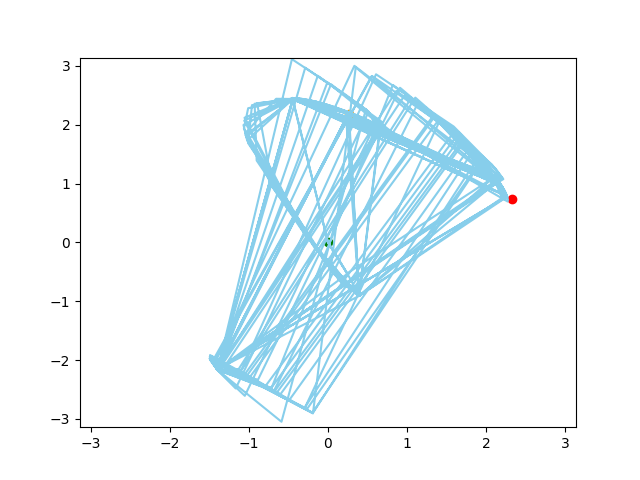

[[ 0.26491004  2.19081127  2.79335461 -1.44322927]] [[ 2.32865188  0.73296797  0.16116229 -1.7614149 ]]


In [23]:
%matplotlib notebook

# if mpc_mpnet.reached:
path = np.array(mpc_mpnet.path)
plt.plot(path[:,0], path[:,1], color='skyblue')
plt.scatter(ref_path[0,0], ref_path[0,1], color='green')
plt.scatter(ref_path[-1,0], ref_path[-1,1], color='red')
plt.scatter(mpc_mpnet.state[:,0], mpc_mpnet.state[:,1], color='orange')

samples = np.array(mpc_mpnet.samples)
# plt.scatter(samples[:,0], samples[:,1], color='green')
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

print(mpc_mpnet.state, mpc_mpnet.goal)

In [15]:
# %matplotlib notebook
# samples = np.array(mpc_mpnet.samples)
# plt.plot(samples[:,0], samples[:,1], color='green')
# plt.scatter(ref_path[0,1], ref_path[0,1], color='orange')
# plt.scatter(ref_path[-1,1], ref_path[-1,1], color='red')

<IPython.core.display.Javascript object>


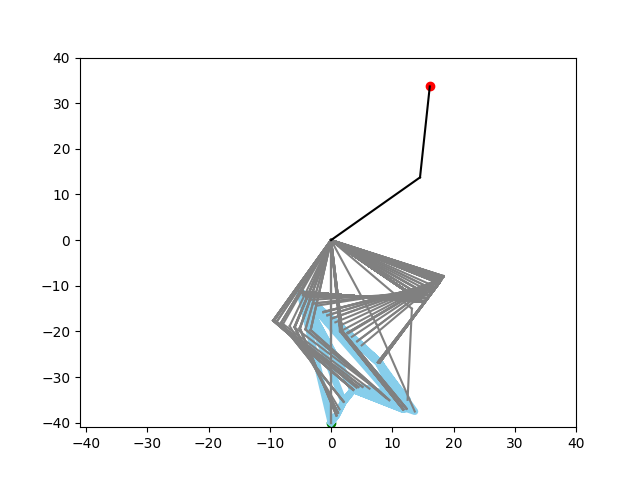

(-41.0, 40.0)

In [16]:
%matplotlib notebook

endeff = []#[[0, -40]]
node1 = []#[[0, -20]]
for p in path:
    ex1, ey1, ex2, ey2 = visualize_point(p)
    endeff.append([ex2, ey2])
    node1.append([ex1, ey1])

endeff = np.array(endeff)
node1 = np.array(node1)
x1, y1, x2, y2 = visualize_point(ref_path[-1])


plt.plot(endeff[:,0], endeff[:,1], color='skyblue', linewidth=5)
plt.scatter(endeff[:,0], endeff[:,1], color='blue', s=1)

for i in range(endeff.shape[0]):
    plt.plot([0, node1[i,0]], [0, node1[i,1]], color='gray')
    plt.plot([node1[i,0], endeff[i,0]], [node1[i,1], endeff[i,1]], color='gray')
plt.plot([0, x1], [0, y1], color='black')
plt.plot([x1, x2], [y1, y2], color='black')
    
plt.scatter(endeff[0, 0], endeff[0, 1], color='green')
plt.scatter(x2, y2, color='red')
plt.xlim(-41, 40)
plt.ylim(-41, 40)
